# **Waze Project**
**Milestone 5 / 5a - Regression analysis: Build a regression model. Evaluate the model**

# **Regression modeling**


**The purpose** of this project is to conduct exploratory data analysis (EDA) and build a binomial logistic regression model.

**The goal** is to build a binomial logistic regression model and evaluate the model's performance.
<br/>

*This notebook has three parts:*

**Part 1:** EDA & Checking Model Assumptions

**Part 2:** Model Building, Results, and Evaluation

**Part 3:** Conclusions, Insights, and Recommendations



### **Imports and data loading**

In [1]:

# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


In [4]:
# Load the dataset by running this cell
df = pd.read_csv('https://raw.githubusercontent.com/adacert/waze/main/Synthetic_Waze_Data_14999%20-%20Fictional_Waze_Data_14999.csv')

## **Part 1. Explore data with EDA & Checking model assumptions**


In [5]:
print(df.shape)

df.info()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


The label column is missing 700 values

In [6]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


Remove the ID column since we don't need this information.

In [7]:
df = df.drop('ID', axis=1)

Class balance of the dependent (target) variable, `label`.

In [8]:
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

In [9]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


The following columns all seem to have outliers:

sessions,
drives,
total_sessions,
total_navigations_fav1,
total_navigations_fav2,
driven_km_drives,
duration_minutes_drives

The maximum values of all these columns surpass the 75th percentile by multiple standard deviations, suggesting the presence of potential outliers in these variables.

### **Create features**


In [10]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Call `describe()` on the new column
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Note that some values are infinite. This is the result of there being values of zero in the `driving_days` column. 

In [11]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

Creates a new, binary feature called `professional_driver` that is a 1 for users who had 100 or more drives <u>**and**</u> drove on 20+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. 

In [12]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [13]:
# 1. Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# 2. Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

0    12405
1     2594
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

The churn rate among professional drivers stands at 7.6%, whereas non-professionals experience a churn rate of 19.9%. This observation appears to contribute a valuable predictive signal to the model.

### **Preparing variables**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int64  
dtypes: float64(4), int64(8

In [15]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

#### **Impute outliers**

Calculate the **95th percentile** of each column and change to this value any value in the column that exceeds it.


In [16]:
# Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

In [17]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


#### **Encode categorical variables**

In [18]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Checking assumptions**

The following are the assumptions for  this logistic regression:

* Independent observations

* No extreme outliers

* Little to no multicollinearity among X predictors

* Linear relationship between X and the **logit** of y

#### **Collinearity**


In [20]:
# Generate a correlation matrix
df.corr(method='pearson')

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259


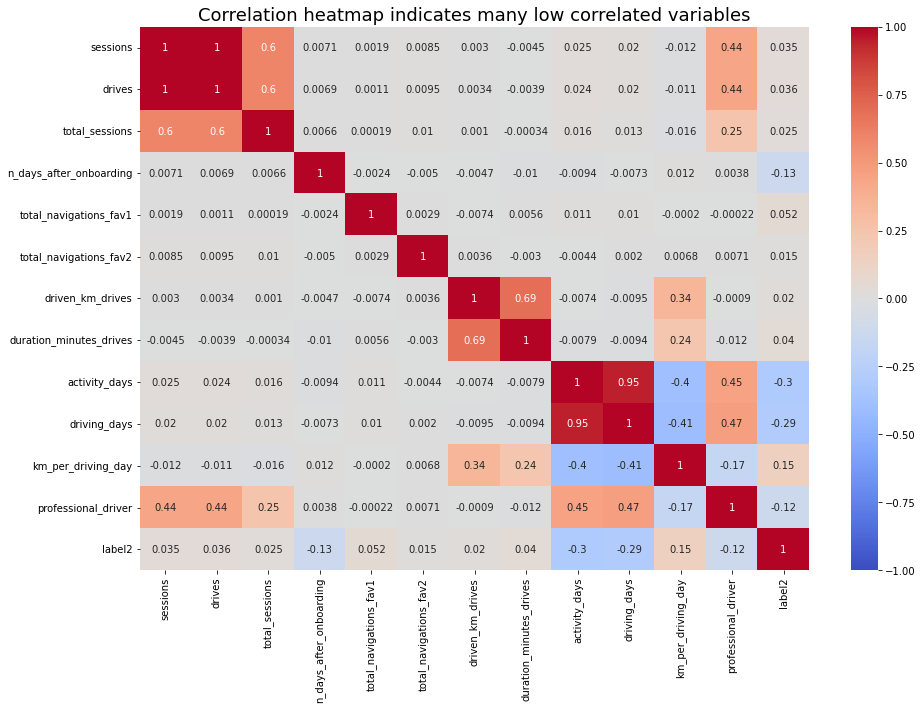

In [22]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show();

Variables that are multicollinear with each other?
 - sessions and drives: 1.0
 - driving_days and activity_days: 0.95

### **Create dummies**
Creates a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [23]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


## **Part 2. Model building, Results, and Evaluation**

#### **Assign predictor variables and target**

In [24]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [25]:
# Isolate target variable
y = df['label2']

#### **Split the data**

In [26]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [27]:
# Use .head()
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


#### **Instantiate a logistic regression model**

Add the argument `penalty = None`.

We add `penalty = None` since the predictors are unscaled.


In [30]:
model = LogisticRegression(penalty='none', max_iter=400)

model.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001913
total_sessions             0.000327
n_days_after_onboarding   -0.000406
total_navigations_fav1     0.001232
total_navigations_fav2     0.000931
driven_km_drives          -0.000015
duration_minutes_drives    0.000109
activity_days             -0.106032
km_per_driving_day         0.000018
professional_driver       -0.001529
device2                   -0.001041
dtype: float64

In [32]:
model.intercept_

array([-0.00170675])

#### **Check final assumption**

Verifies the linear relationship between X and the estimated log odds (known as logits) by making a regplot.

In [33]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93963483, 0.06036517],
       [0.61967304, 0.38032696],
       [0.76463181, 0.23536819],
       ...,
       [0.91909641, 0.08090359],
       [0.85092112, 0.14907888],
       [0.93516293, 0.06483707]])

Below creates a dataframe called `logit_data` that is a copy of `df`.

Below also creates a new column called `logit` in the `logit_data` dataframe. The data in this column should represent the logit for each user.


In [34]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

Below creates a dataframe called `logit_data` that is a copy of `df`.

Below also creates a new column called `logit` in the `logit_data` dataframe. The data in this column should represent the logit for each user.


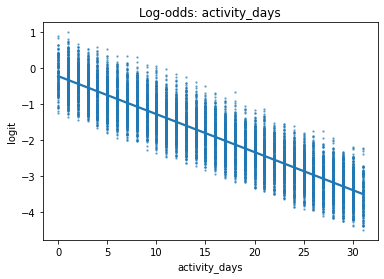

In [35]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

### **Results and evaluation**

If the logistic assumptions are met, the model results can be appropriately interpreted.

Below we will make predictions on the test data.


In [36]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

**Accuracy of the model**

In [37]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8237762237762237

### **Results shown with a confusion matrix**

In [53]:
cm = confusion_matrix(y_test, y_preds)

The below confusion matrix shows an error, but displays correctly.

TypeError: 'NoneType' object is not iterable

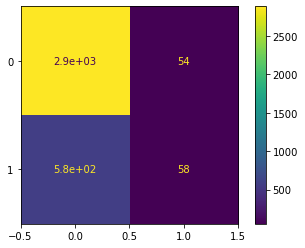

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=None)
disp.plot()

**Precision**

In [55]:
# Calculate precision manually
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.5178571428571429

**Recall**

In [56]:
# Calculate recall manually
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.0914826498422713

**Classification Report**

In [57]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



Although the model demonstrates reasonable precision, its recall is extremely low, indicating a high number of false negative predictions. Consequently, it fails to identify and capture users who are likely to churn.

**Visual representation of the importance of the model's features**

In [58]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('drives', 0.001913369447769776),
 ('total_navigations_fav1', 0.001231754741616306),
 ('total_navigations_fav2', 0.0009314786513814626),
 ('total_sessions', 0.00032707088819142904),
 ('duration_minutes_drives', 0.00010909343558951453),
 ('km_per_driving_day', 1.8223094015325207e-05),
 ('driven_km_drives', -1.4860453424647997e-05),
 ('n_days_after_onboarding', -0.00040647763730561445),
 ('device2', -0.0010412175209008018),
 ('professional_driver', -0.0015285041567402024),
 ('activity_days', -0.10603196504385491)]

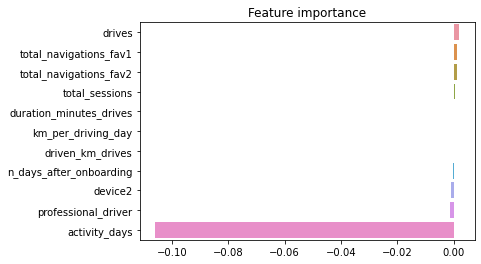

In [59]:
# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

### **Part 3: Conclusions, Insights, and Recommendations**

**Variables that most influenced the model's prediction:** 
 - Among all the features in the model, "activity_days" emerged as the most significant one, exhibiting a negative correlation with user churn. This finding is not unexpected since "activity_days" is highly correlated with "driving_days," which was already identified during the exploratory data analysis (EDA) to have a negative correlation with churn.
 
**Variables expected to be stronger predictors than they were:**
 - During the exploratory data analysis (EDA), it was observed that the user churn rate rose in conjunction with increasing values in "km_per_driving_day." The correlation heatmap in this notebook further confirmed this observation, indicating that this variable exhibited the highest positive correlation with churn among all the predictor variables, surpassing others by a significant margin. Surprisingly, in the model, "km_per_driving_day" ranked as the second-least important variable.
 
**Why might a variable thought to be important not be important in the model?**
 - In a multiple logistic regression model, the presence of feature interactions can lead to relationships that may appear counterintuitive. This phenomenon represents both a strength and a weakness of predictive models. On one hand, capturing these interactions enhances the predictive capabilities of the model. On the other hand, it complicates the model's interpretability, making it more challenging to explain the underlying relationships.
 
**Is it recommended that Waze use this model?**
 - The usefulness of the model depends on its intended purpose. If the model is employed to inform critical business decisions, its performance may not be sufficiently strong, particularly evident from its low recall score. However, if the model is primarily utilized to guide further exploratory efforts and provide insights, it can still offer value in that context.
 
**Steps that can be taken to improve this model:**
 - By leveraging domain knowledge, it is possible to engineer new features aimed at improving predictive signal. In the context of this model, one of the engineered features, namely "professional_driver," emerged as the third-most influential predictor. Additionally, scaling the predictor variables and reconstructing the model using different combinations of predictors can be beneficial in minimizing noise stemming from unpromising features.

**Additional features that would be needed to help improve the model:**
 - It would be beneficial to possess drive-level specifics for individual users, such as drive times and geographic locations. Furthermore, obtaining more detailed information regarding how users engage with the app would likely provide valuable insights. For instance, understanding the frequency at which they report or confirm road hazard alerts. Finally, having knowledge of the monthly count of distinct starting and ending locations inputted by each driver could offer valuable additional information.


In [1]:
import nbformat

def extract_code_from_ipynb(ipynb_file, output_file):
    with open(ipynb_file, 'r', encoding='utf-8') as file:
        notebook = nbformat.read(file, as_version=4)
        
    code_cells = [cell['source'] for cell in notebook['cells'] if cell['cell_type'] == 'code']
    
    with open(output_file, 'w', encoding='utf-8') as file:
        for i, code in enumerate(code_cells, 1):
            file.write(code)
            file.write('\n\n')

# Replace 'notebook.ipynb' and 'output.py' with your file names
extract_code_from_ipynb('Waze Milestone 5 and 5a.ipynb', 'Waze_5_code.py')